In [0]:
import gzip
from google.colab import drive

drive.mount('/drive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
cd ../drive/My\ Drive/Final\ Project

/drive/My Drive/Final Project


In [0]:
cd Gomoku\ Data

/drive/My Drive/Final Project/Gomoku Data


In [0]:
ls

add/                    full_nice_dataset.txt  MST-MM-40.bdt  ShowRenju.exe
full_dataset.txt        Gomoku.bdt             PBeMSort.bdt
full_nice_dataset.gdoc  ini/                   rps.bdt


Now, let's convert to a training set of matrices + labels corresponding to next moves. Will also consider removing duplicates.

In [0]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

def get_numerical_index(penta):
  if penta in [str(i) for i in range(11)]:
    return int(penta) - 1
  return 9 + ord(penta) - ord('A')

def get_move_label(letter_a,letter_b):
  a = get_numerical_index(letter_a)
  b = get_numerical_index(letter_b)

  return 15*a+b

def add_move(board_state,letter_a,letter_b,player = 1):
  a = get_numerical_index(letter_a)
  b = get_numerical_index(letter_b)
  if player == 1:
    board_state[a,b,0] = 1
    board_state[a,b,1] = 0
    board_state[a,b,2] = 0
  else:
    board_state[a,b,0] = 0
    board_state[a,b,1] = 1
    board_state[a,b,2] = 0

def add_game(board_data,move_data,player_data,game_string):
  n = len(game_string)
  # initialize the board state with empty = (0,0,1) with one-hot encoding
  board_state = np.zeros((15,15,3))
  board_state[:,:,2]  = 1
  for i in range(int(n/2)-1):
    add_move(board_state,game_string[2*i],game_string[2*i+1],player = (i+1)%2)
    board_data.append(board_state)
    move_data.append(get_move_label(game_string[2*i+2],game_string[2*i+3]))
    player_data.append((i+1)%2)

def load_all_games():
  # first, load the games dataset
  f = open("full_nice_dataset.txt",encoding='latin-1')
  line = f.readline()
  loaded_data = []
  while line:
    loaded_data.append(line.replace("\n",""))
    line = f.readline()
  f.close()
  return loaded_data

def convert_all_games(loaded_data):
  # then, iterate through the games, convert each game to board data and add to the list of boards
  all_boards = []
  all_next_moves = []
  all_players = []

  for i in range(len(loaded_data)):
    add_game(all_boards,all_next_moves,all_players,loaded_data[i])

  # some additional preprocessing - let's switch X and O on the board when needed such that the player about to make move is always X
  for i in range(len(all_boards)):
    if all_players[i] == 1:
      flipped_boardsi = np.array(all_boards[i])
      flipped_boardsi[:,:,0] = all_boards[i][:,:,1]
      flipped_boardsi[:,:,1] = all_boards[i][:,:,0]
      all_boards[i] = flipped_boardsi
  
  return all_boards,all_next_moves

In [0]:
def compare_boards(board_a,board_b):
  for i in range(15):
    for j in range(15):
      for k in range(3):
        if board_a[i,j,k] > board_b[i,j,k]:
          return 1
        if board_b[i,j,k] > board_a[i,j,k]:
          return -1
  return 0

def compare_objects(bm_a,bm_b):
  return compare_boards(bm_a.board,bm_b.board)

class BoardMove:
  def __init__(self,board, move):
    self.board = board
    self.move = move

def get_array_of_objects(boards,moves):
  num_examples = len(boards)
  arr_objects = []
  for i in range(num_examples):
    arr_objects.append(BoardMove(boards[i],moves[i]))
  return arr_objects

In [0]:
loaded_games = load_all_games()
boards,moves = convert_all_games(loaded_games)
board_moves = get_array_of_objects(boards,moves)

113


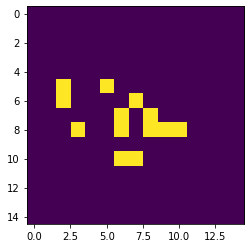

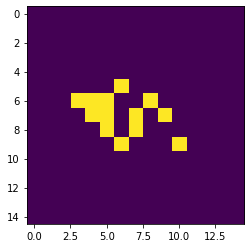

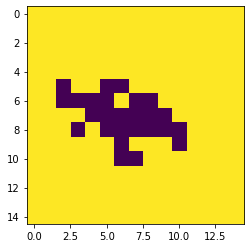

8889869A96997978AB9798B78A9B76668587A7B867947463757365


In [0]:
print(moves[0])

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(board_moves[0].board[:,:,0])
plt.show()

plt.figure()
plt.imshow(board_moves[0].board[:,:,1])
plt.show()

plt.figure()
plt.imshow(board_moves[0].board[:,:,2])
plt.show()

print(loaded_games[0])

In [0]:
from functools import cmp_to_key
short_board_moves = [board_moves[i] for i in range(50000)]
len(board_moves)
board_moves.sort(key = cmp_to_key(compare_objects))

In [0]:
import statistics
from tqdm import tqdm_notebook as tqdm

def merge_duplicates(board_moves):
  num_examples = len(board_moves)
  non_duplicate_boards = [board_moves[0].board]
  arr_of_moves = [[board_moves[0].move]]
  for i in tqdm(range(1,num_examples)):
    if compare_objects(board_moves[i-1],board_moves[i]) != 0:
      non_duplicate_boards.append(board_moves[i].board)
      arr_of_moves.append([board_moves[i].move])
    else:
      arr_of_moves[-1].append(board_moves[i].move)
  return (non_duplicate_boards,arr_of_moves)

def only_best_move(new_moves):
  only_best = []
  len_moves = len(new_moves)
  for i in tqdm(range(len_moves)):
    try:
      only_best.append(statistics.mode(new_moves[i]))
    except:
      only_best.append(statistics.median_high(new_moves[i]))
  return only_best

In [0]:
good_boards,arr_moves = merge_duplicates(board_moves)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
good_moves = only_best_move(arr_moves)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
print(len(good_boards))
print(len(good_moves))

18081
18081


Now let's define the simple model from Kun Shao, Dongbin Zhao, Zhentao Tang, and Yuanheng Zhu's paper.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 15, 15, 16)        1216      
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 16)        2320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 16)        2320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 225)              

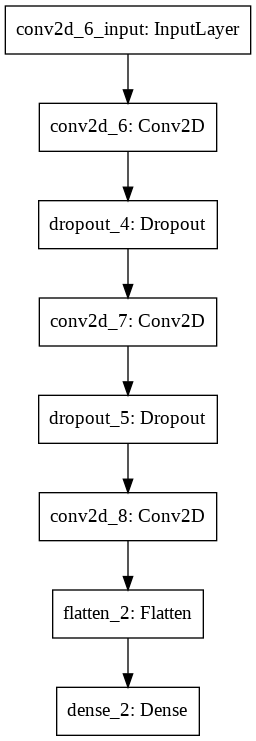

In [0]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters = 16, kernel_size = 5, activation = 'relu', padding = 'SAME', input_shape = (15,15,3)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'SAME'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'SAME'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(225, activation = 'softmax'))

model.summary()
keras.utils.plot_model(model)

In [0]:
import random

# first, we need to shuffle the two arrays
together = list(zip(boards,moves))
random.shuffle(together)
boards, moves = zip(*together)

boards = np.array(good_boards)
moves = np.array(good_moves)

X_train = boards[2000:,:,:,:]
X_valid = boards[:2000,:,:,:]
y_train = moves[2000:]
y_valid = moves[:2000]

print(boards.shape)
print(X_train.shape)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train,y_train,validation_data = (X_valid,y_valid),epochs = 10, batch_size=32, shuffle = True)

(18081, 15, 15, 3)
(16081, 15, 15, 3)
Epoch 1/10
503/503 [==============================] - 2s 4ms/step - loss: 2.8601 - accuracy: 0.2040 - val_loss: 1.9565 - val_accuracy: 0.4220
Epoch 2/10
503/503 [==============================] - 2s 4ms/step - loss: 1.8548 - accuracy: 0.3661 - val_loss: 1.6091 - val_accuracy: 0.5060
Epoch 3/10
503/503 [==============================] - 2s 4ms/step - loss: 1.5411 - accuracy: 0.4423 - val_loss: 1.5587 - val_accuracy: 0.4940
Epoch 4/10
503/503 [==============================] - 2s 4ms/step - loss: 1.3531 - accuracy: 0.5001 - val_loss: 1.4978 - val_accuracy: 0.5325
Epoch 5/10
503/503 [==============================] - 2s 4ms/step - loss: 1.2264 - accuracy: 0.5391 - val_loss: 1.4809 - val_accuracy: 0.5370
Epoch 6/10
503/503 [==============================] - 2s 4ms/step - loss: 1.1063 - accuracy: 0.5852 - val_loss: 1.5584 - val_accuracy: 0.5040
Epoch 7/10
503/503 [==============================] - 2s 4ms/step - loss: 1.0282 - accuracy: 0.6108 - val_loss

In [0]:
print(history.history)

{'loss': [0.30819171667099, 0.2889452874660492, 0.2690204977989197, 0.25687241554260254, 0.25183647871017456, 0.25346246361732483, 0.2440362423658371, 0.2406700700521469, 0.2213643491268158, 0.2188292145729065], 'accuracy': [0.8878800868988037, 0.8926683664321899, 0.8995087146759033, 0.9067844152450562, 0.9044213891029358, 0.9088365435600281, 0.9090852737426758, 0.9108886122703552, 0.9164853096008301, 0.9217710494995117], 'val_loss': [1.266157627105713, 1.3174080848693848, 1.4129855632781982, 1.4321420192718506, 1.5181366205215454, 1.6222895383834839, 1.6408886909484863, 1.570783257484436, 1.8156628608703613, 1.637308120727539], 'val_accuracy': [0.6365000009536743, 0.6209999918937683, 0.6150000095367432, 0.6065000295639038, 0.6044999957084656, 0.5914999842643738, 0.5950000286102295, 0.6065000295639038, 0.5519999861717224, 0.593500018119812]}


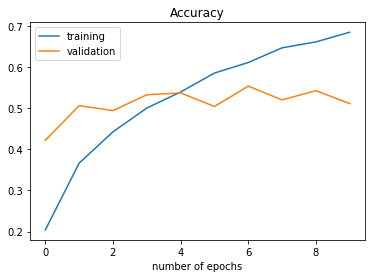

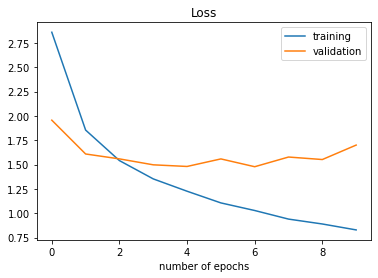

In [0]:
plt.figure()
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.xlabel('number of epochs')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('number of epochs')
plt.title('Loss')
plt.legend()
plt.show()

176


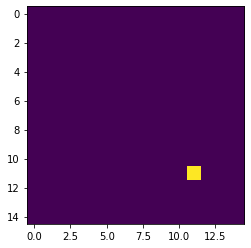

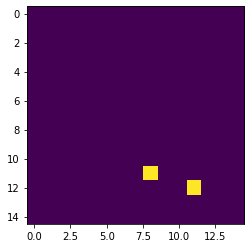

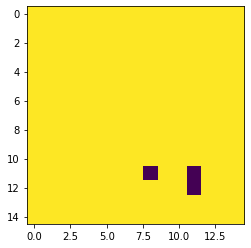

In [0]:
print(board_moves[0].move)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(board_moves[0].board[:,:,0])
plt.show()

plt.figure()
plt.imshow(board_moves[0].board[:,:,1])
plt.show()

plt.figure()
plt.imshow(board_moves[0].board[:,:,2])
plt.show()

#print(loaded_games[1])

In [0]:
class Board:
  def __init__(self):
    